In [4]:
import random
import time
import math
import numpy as np
import pylab as py
import rasterio
import cv2
import rasterio
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score


In [7]:
def data_input():
    print("\n Input the source image file: \n")
    tk.Tk().withdraw()
    Source_image = filedialog.askopenfilename()
    print(Source_image)
    img=rasterio.open(Source_image)
    img=img.read()
    imgarr=np.moveaxis(img,0,-1)
    Xs=imgarr#[216:716,235:735,:-1]
    Xs=Xs.reshape(Xs.shape[0]*Xs.shape[1],Xs.shape[2])
    Xs_norm = (Xs-np.min(Xs))/(np.max(Xs)- np.min(Xs))

    print("\n Input the ground_truth_file: \n")
    tk.Tk().withdraw()
    GT_file = filedialog.askopenfilename()
    print(GT_file)
    y=rasterio.open(GT_file)
    y=y.read()
    y=np.moveaxis(y,0,-1)
    yt=y.reshape(y.shape[0]*y.shape[1])
        
        #label_encoding
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    labels= label_encoder.fit_transform(yt)
       
    return Xs_norm, labels,imgarr

In [13]:
X_s, labels, image_s=data_input()
rows=image_s.shape[0]
cols=image_s.shape[1]


 Input the source image file: 

E:/Anagha/Dataset/Rabi/30m/Iexp_A423_REF.tiff

 Input the ground_truth_file: 

E:/Anagha/Evolution/EI_related/30m_A423_gt.tif


In [4]:
num_bands=X_s.shape[1]
num_pixels=X_s.shape[0]
num_classes=len(np.unique(labels)[1:])

In [6]:
import pandas as pd

def sample_data(data, labels):
    df  = pd.DataFrame(data[labels!=0])
    df['label'] = labels[labels!=0]  # Add labels as a new column

    # Group by the 'label' column and take the first 1000 samples from each class
    sampled_df  = df.groupby('label').head(6000)

    # data and labels as separate arrays:
    sampled_data  = sampled_df.drop('label', axis=1).to_numpy()
    sampled_labels  = sampled_df['label'].to_numpy()
    return sampled_data, sampled_labels

In [7]:
def valuation_fn(data, labels):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import cohen_kappa_score
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import f1_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    X_train, X_test, y_train, y_test = train_test_split(data,labels,random_state=42,stratify=labels)
    count={}
    for i in range (1,len(np.unique(y_test))+1):
        counts=len(np.where(y_test==i)[0])
        count[i]=counts
    print(count)

    from sklearn.svm import SVC
    model2=RidgeClassifier()
    model6=SVC(kernel='rbf',probability=True)
    model10=RandomForestClassifier(n_estimators=100)
    ensemble = VotingClassifier(estimators=[('SVC', model6),('RF', model10),('Ridge', model2)], voting='hard')
    fit_model=ensemble.fit(X_train, y_train) 
    y_pred=fit_model.predict(X_test) 


    conf_matrix = confusion_matrix(y_test ,y_pred)
    cohen_kappa_score_vals = cohen_kappa_score(y_test ,y_pred)
    balanced_accuracy_score_vals = balanced_accuracy_score(y_test ,y_pred)
    accuracy_score_vals = accuracy_score(y_test ,y_pred)
    classification_report_vals = classification_report(y_test ,y_pred)
    f1_score_vals = f1_score(y_test ,y_pred, average='weighted')
    precision_score_vals = precision_score(y_test ,y_pred,average='weighted')
    #precision = precision_score(y_test ,y_pred, labels=[1, 2, 3], average='micro')
    recall_score_vals = recall_score(y_test ,y_pred, average='weighted')


    print("confusion_matrix = "'\n', conf_matrix,'\n', "cohen_kappa_score = ", cohen_kappa_score_vals,'\n',"balanced_accuracy_score = ",balanced_accuracy_score_vals,'\n',"accuracy_score = ",accuracy_score_vals, '\n', "classification_report ="'\n',classification_report_vals,"f1_score = ",f1_score_vals,'\n', "precision_score = ", precision_score_vals,'\n', "recall_score = ",recall_score_vals)
    return balanced_accuracy_score_vals, conf_matrix, classification_report, fit_model

In [8]:
sampled_data_full, sampled_labels_full = sample_data(X_s, labels)

In [9]:
accuracy_full, conf_matrix_full, classification_report_full, fit_model_full=valuation_fn(sampled_data_full, sampled_labels_full)

{1: 1500, 2: 1500, 3: 1500}
confusion_matrix = 
 [[1468    0   32]
 [   0 1455   45]
 [   1   24 1475]] 
 cohen_kappa_score =  0.966 
 balanced_accuracy_score =  0.9773333333333333 
 accuracy_score =  0.9773333333333334 
 classification_report =
               precision    recall  f1-score   support

           1       1.00      0.98      0.99      1500
           2       0.98      0.97      0.98      1500
           3       0.95      0.98      0.97      1500

    accuracy                           0.98      4500
   macro avg       0.98      0.98      0.98      4500
weighted avg       0.98      0.98      0.98      4500
 f1_score =  0.9774341012789104 
 precision_score =  0.9778262274055839 
 recall_score =  0.9773333333333334


In [11]:
print("\n Input the wavelength file: \n")
tk.Tk().withdraw()
wavelength_file = filedialog.askopenfilename()
print(wavelength_file)
wavelengths=np.loadtxt(wavelength_file)
wv= {}
for i in range(0,X_s.shape[1]):
    wv[i] = wavelengths[i]


 Input the wavelength file: 

E:/Anagha/Germandronework/Rabi/wavelength.txt


Select a location to save the figure:


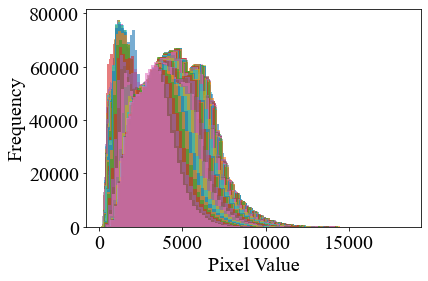

In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 20  
})
    # Compute the distribution for each band
for band in range(image_s.shape[2]-1):
    data = image_s[:, :, band].flatten()
    plt.hist(data, bins=50, alpha=0.6, label=f'Band {band+1}')
    
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
#plt.title('Histogram of Hyperspectral Bands')
tk.Tk().withdraw()

print("Select a location to save the figure:")
save_file_path = filedialog.asksaveasfilename()
print(save_file_path)
plt.savefig(save_file_path, dpi = 600,bbox_inches='tight')
plt.show()


In [15]:
image_s=image_s.reshape(image_s.shape[0]*image_s.shape[1], image_s.shape[2])

In [17]:
import numpy as np
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

data_class_A = images_s[labels==1][:,:-1] 
data_class_B = images_s[labels==2][:,:-1]
data_class_C = images_s[labels==3][:,:-1]


# Function to fit Weibull distribution and return shape and scale parameters
def fit_weibull(data):
    shape, loc, scale = weibull_min.fit(data, floc=0)
    return shape, scale

# Calculate Weibull parameters for each class and band
weibull_params_A = [fit_weibull(data_class_A[:, i]) for i in range(data_class_A.shape[1])]
weibull_params_B = [fit_weibull(data_class_B[:, i]) for i in range(data_class_B.shape[1])]
weibull_params_C = [fit_weibull(data_class_C[:, i]) for i in range(data_class_C.shape[1])]


import numpy as np
from scipy.integrate import quad

# Weibull PDF
def weibull_pdf(x, shape, scale):
    return (shape / scale) * (x / scale)**(shape - 1) * np.exp(-(x / scale)**shape)

# Bhattacharyya coefficient for two Weibull distributions
def bhattacharyya_coefficient(shape1, scale1, shape2, scale2):
    integrand = lambda x: np.sqrt(weibull_pdf(x, shape1, scale1) * weibull_pdf(x, shape2, scale2))
    bc, _ = quad(integrand, 0, np.inf)
    return bc

# Bhattacharyya distance for two distributions
def bhattacharyya_distance(shape1, scale1, shape2, scale2):
    bc = bhattacharyya_coefficient(shape1, scale1, shape2, scale2)
    return -np.log(bc)

# Compute the separability for each band between Class A and B
separability_AB = [bhattacharyya_distance(weibull_params_A[i][0], weibull_params_A[i][1],
                                        weibull_params_B[i][0], weibull_params_B[i][1])
                 for i in range(data_class_A.shape[1])]

# Compute the separability for each band between Class B and C
separability_BC = [bhattacharyya_distance(weibull_params_B[i][0], weibull_params_B[i][1],
                                        weibull_params_C[i][0], weibull_params_C[i][1])
                 for i in range(data_class_B.shape[1])]

separability_AC = [bhattacharyya_distance(weibull_params_A[i][0], weibull_params_A[i][1],
                                        weibull_params_C[i][0], weibull_params_C[i][1])
                 for i in range(data_class_A.shape[1])]


selected_bands_AB = np.argsort(separability_AB)[-(int(images_s.shape[1]/4)):] 
selected_bands_BC = np.argsort(separability_BC)[-(int(images_s.shape[1]/4)):] 
selected_bands_AC = np.argsort(separability_AC)[-(int(images_s.shape[1]/4)):] 

def combined_bands(a,b,c): 
    combined = np.concatenate((a, b, c))
    unique_combined = np.unique(combined)
    return unique_combined 

selected_bands = combined_bands(selected_bands_AB, selected_bands_BC, selected_bands_AC)



C:\ProgramData\Anaconda3\envs\anagha\lib\site-packages\ipykernel_launcher.py:31: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


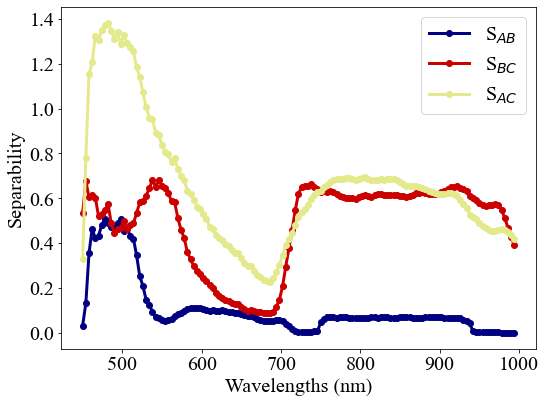

In [14]:
user_colors = [ 'navy', '#CB0000', '#E4EA8C']

legend_label=['S$_{AB}$', 'S$_{BC}$','S$_{AC}$']
# Plotting the spectral signatures
plt.figure(figsize=(8,6))

plt.plot(wavelengths[:-1], separability_AB, marker='o', linewidth=3, color= user_colors[0], label=legend_label[0])
plt.plot(wavelengths[:-1], separability_BC, marker='o',linewidth=3,color= user_colors[1],label=legend_label[1])
plt.plot(wavelengths[:-1], separability_AC, marker='o',linewidth=3,color= user_colors[2],label=legend_label[2])

# Add common x-axis label and adjust layout
plt.xlabel("Wavelengths (nm)")
plt.ylabel("Separability")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))
tk.Tk().withdraw()

print("Select a location to save the figure:")
save_file_path = filedialog.asksaveasfilename()
print(save_file_path)
plt.savefig(save_file_path, dpi = 600,bbox_inches='tight')
plt.show()

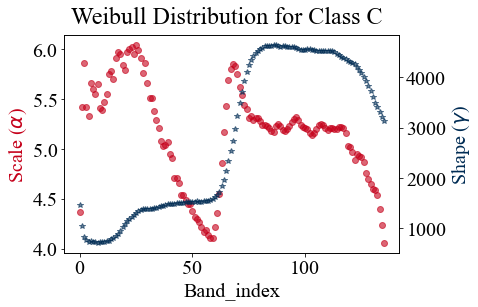

In [15]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()


for i in range(len(weibull_params_C)-1):
    ax1.plot(i, weibull_params_C[i][0], color='#C5001A', marker = 'o', alpha=0.6)

# Set the labels and title for the first y-axis
ax1.set_xlabel('Band_index')
ax1.set_ylabel(r'Scale ($\alpha$)',color='#C5001A')
ax1.tick_params(axis='y')#, labelcolor='g')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second set of Weibull parameters on the second y-axis
for i in range(len(weibull_params_C)-1):
    ax2.plot(i, weibull_params_C[i][1], color ='#002C54', marker = '*', alpha=0.6)

# Set the labels for the second y-axis
ax2.set_ylabel(r'Shape ($\gamma$)',color='#002C54')
ax2.tick_params(axis='y')

# Adding legend and title
fig.suptitle('Weibull Distribution for Class C')
tk.Tk().withdraw()

print("Select a location to save the figure:")
save_file_path = filedialog.asksaveasfilename()
print(save_file_path)
plt.savefig(save_file_path, dpi=600,bbox_inches='tight', pad_inches=0)
# Display the plot
plt.show()


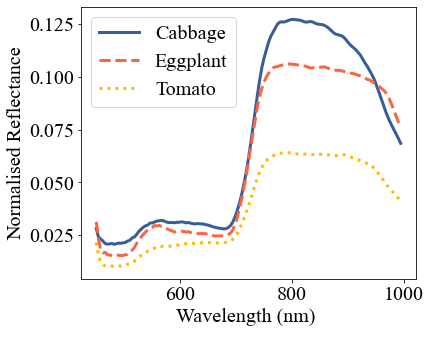

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


classes = {}
class_means = {}
lb = np.unique(labels)[1:] 

user_colors = [ '#375E97', '#FB6542', '#FFBB00'] 

for i in lb:
    # Select data for each class
    class_data = X_s[labels == i]    
    class_sig = np.mean(class_data[:6000, :-1],axis=0)
    class_means[f'class{i}_mean'] = class_sig  

# Create a DataFrame from the class means dictionary
class_means_df = pd.DataFrame.from_dict(class_means, orient='index')
legend_label=['Cabbage', 'Eggplant','Tomato']
label_linestyle=["-", "--",":"]
# Plotting the spectral signatures
plt.figure(figsize=(6,5))
for i in range(len(lb)):
    plt.plot(wavelengths[:-1], class_means_df.iloc[i], color=user_colors[i % len(user_colors)], label=legend_label[i % len(legend_label)], linestyle=label_linestyle[i % len(label_linestyle)], linewidth=3)

# Add legends and labels
plt.legend()
plt.xlabel('Wavelength (nm) \n')
plt.ylabel('Normalised Reflectance')
#plt.title('Spectral_Signature of Crops')
tk.Tk().withdraw()

print("Select a location to save the figure:")
save_file_path = filedialog.asksaveasfilename()
print(save_file_path)
plt.savefig(save_file_path, dpi=600, bbox_inches='tight')
# Show the plot
plt.show()


In [18]:
print(len(selected_bands))

73

In [20]:
selected_values = {k: wv[k] for k in selected_bands if k in wv}
X_sreduced=X_s[:,selected_bands]

In [20]:
array_Weibull1=[]
array_Weibull2=[]
array_Weibull3=[]
array_Weibull4=[]
array_Weibull5=[]
array_Weibull6=[]

for i in range(0,len(selected_values)):
    if 450<=(list(selected_values.values())[i])<550:
        array_Weibull1.append(list(selected_values.values())[i])
    if 550<=(list(selected_values.values())[i])<650:
        array_Weibull2.append(list(selected_values.values())[i])
    if 650<=(list(selected_values.values())[i])<750:
        array_Weibull3.append(list(selected_values.values())[i])
    if 750<=(list(selected_values.values())[i])<850:
        array_Weibull4.append(list(selected_values.values())[i])
    if 850<=(list(selected_values.values())[i])<950:
        array_Weibull5.append(list(selected_values.values())[i])
    if 950<=(list(selected_values.values())[i])<1050:
        array_Weibull6.append(list(selected_values.values())[i])
        
print("\n Weibull wavelengths:\n")       
print("Wavelengths in range 450-550 nm:", array_Weibull1)
print("Wavelengths in range 550-650 nm:", array_Weibull2)
print("Wavelengths in range 650-750 nm:", array_Weibull3)
print("Wavelengths in range 750-850 nm:", array_Weibull4)
print("Wavelengths in range 850-950 nm:", array_Weibull5)
print("Wavelengths in range 950-1050 nm:", array_Weibull6)

print("Wavelengths in range 450-550 nm:",len(array_Weibull1))
print("Wavelengths in range 550-650 nm:", len(array_Weibull2))
print("Wavelengths in range 650-750 nm:", len(array_Weibull3))
print("Wavelengths in range 750-850 nm:",len (array_Weibull4))
print("Wavelengths in range 850-950 nm:",len (array_Weibull5))
print("Wavelengths in range 950-1050 nm:",len (array_Weibull6))


 Weibull wavelengths:

Wavelengths in range 450-550 nm: [454.0, 458.0, 462.0, 466.0, 470.0, 474.0, 478.0, 482.0, 486.0, 490.0, 494.0, 498.0, 502.0, 506.0, 510.0, 514.0, 518.0, 522.0, 526.0, 530.0, 534.0, 538.0, 542.0, 546.0]
Wavelengths in range 550-650 nm: [550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574.0, 578.0, 582.0, 586.0, 590.0, 594.0, 598.0, 602.0, 606.0, 610.0, 614.0, 622.0, 626.0, 630.0]
Wavelengths in range 650-750 nm: [722.0, 726.0, 730.0, 734.0, 738.0, 742.0, 746.0]
Wavelengths in range 750-850 nm: [750.0, 754.0, 758.0, 762.0, 766.0, 786.0, 802.0, 806.0]
Wavelengths in range 850-950 nm: [870.0, 874.0, 878.0, 882.0, 886.0, 902.0, 906.0, 910.0, 914.0, 918.0, 922.0, 926.0, 930.0, 934.0]
Wavelengths in range 950-1050 nm: []
Wavelengths in range 450-550 nm: 24
Wavelengths in range 550-650 nm: 20
Wavelengths in range 650-750 nm: 7
Wavelengths in range 750-850 nm: 8
Wavelengths in range 850-950 nm: 14
Wavelengths in range 950-1050 nm: 0


In [21]:
count={}
for i in range (1,len(np.unique(labels))):
    counts=len(np.where(labels==i)[0])
    count[i]=counts
print(count)

{1: 38432, 2: 38224, 3: 9794}


In [22]:
sampled_data_reduced, sampled_labels_reduced = sample_data(X_sreduced, labels)

In [23]:
accuracy_reduced, conf_matrix_reduced, classification_report_reduced, fit_model_reduced=valuation_fn(sampled_data_reduced,sampled_labels_reduced)

{1: 1500, 2: 1500, 3: 1500}
confusion_matrix = 
 [[1469    0   31]
 [   1 1326  173]
 [   1   64 1435]] 
 cohen_kappa_score =  0.91 
 balanced_accuracy_score =  0.94 
 accuracy_score =  0.94 
 classification_report =
               precision    recall  f1-score   support

           1       1.00      0.98      0.99      1500
           2       0.95      0.88      0.92      1500
           3       0.88      0.96      0.91      1500

    accuracy                           0.94      4500
   macro avg       0.94      0.94      0.94      4500
weighted avg       0.94      0.94      0.94      4500
 f1_score =  0.9402812020044751 
 precision_score =  0.9427103591122745 
 recall_score =  0.94


In [24]:
def accuracy_fn(individual,data, labels): 
    bands=np.where(individual!=0) 
    data=data[:,bands[0]]
    
    #sum of non diagonal elements of correlation matrix
    corrm = np.corrcoef(data, rowvar=False)
    if corrm.ndim >= 2:
        corrsum = np.sum(corrm) - np.trace(corrm)
    else:
        corrsum = np.sum(corrm)
   
    X_temp =pd.DataFrame(data) 
    X_temp['labels']=labels 
    lb=np.unique(labels) 
    classes= {} 
    for i in (lb): 
        classes[ "class{0}"  .format(i)] = X_temp[X_temp['labels']==i]       
    data1=pd.concat(classes.values(), ignore_index=True)#train_test_split 
    Y=data1.iloc[:,-1] 
    X=data1.iloc[:,:-1] 
    X=X.to_numpy() 
    daX=X.copy() 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,shuffle=True,stratify=Y) 
    model2=RidgeClassifier()
    model6=SVC(kernel='rbf',probability=True)
    model10=RandomForestClassifier(n_estimators=100)

    ensemble = VotingClassifier(estimators=[('SVC', model6),('RF', model10),('Ridge', model2)], voting='hard')
    fit_model=ensemble.fit(X_train, y_train) 
    s=fit_model.predict(X_test) 
    accuracy =balanced_accuracy_score(y_test, s) 
    conf_matrix = confusion_matrix(y_test,s)
    if len(conf_matrix)>2:
        tp=[]
        fp=[]
        tn=[]
        fn=[]
        for i in range(conf_matrix.shape[0]):
            TP = conf_matrix[i, i]
            FP = np.sum(conf_matrix[:, i]) - TP
            FN = np.sum(conf_matrix[i, :]) - TP
            TN = np.sum(conf_matrix) - TP - FP - FN
            tp.append(TP)
            fp.append(FP)
            tn.append(TN)
            fn.append(FN)
        tp=np.mean(tp)
        fp=np.mean(fp)
        tn=np.mean(tn)
        fn=np.mean(fn)
    else:
        tn, fp, fn, tp = conf_matrix.ravel()
    FPR=fp/(fp+tn) 
    FNR=fn/(fn+tp) 
    band_ratio= len(bands[0])/len(selected_bands) 
    return accuracy,FPR,FNR,corrsum, band_ratio

In [25]:
def objective_fn(individual,data,labels):  
    accrcy,FPR,FNR,corrsum, band_ratio=accuracy_fn(individual,data,labels) 
    ob1=0.4*((FPR+FNR)/accrcy)
    ob2=0.4*band_ratio 
    ob3=0.2*corrsum
    obj_fn=ob1+ob2+ob3
    return obj_fn,accrcy,corrsum,FPR,FNR,band_ratio

In [26]:
def binerization(pos):
     k = 0
     h = 0
     for i in pos:
         h = 0
         for j in i:
             if (j <= 0.75):
                 pos[k, h] = 0
             else:
                 pos[k, h] = j
             h+=1
         k+=1
     return pos

In [27]:
num_bands = X_sreduced.shape[1]
population_size = 20
num_generations = 10

## Algorithms

In [38]:
import scipy
gamma = scipy.special.gamma

def HHO(data, labels,dim, n, num_generations):
    max_iter=num_generations
    population = np.random.uniform(0,1, (n,dim))
    population=binerization(population)
    #print(population)
    fb = np.array([objective_fn(individual,data,labels) for individual in population])
    fitness=fb[:,0] 
    accuracy=fb[:,1] 
    corrsum=fb[:,2] 
    FPR=fb[:,3] 
    FNR=fb[:,4] 
    band_ratio=fb[:,5]
    valid_indices = (accuracy > 0.88) & (band_ratio > 0.13) ## setting minimum accuracy 0.88 and bands 10

    if np.any(valid_indices): 
        min_fitness = np.min(fitness[valid_indices])  # Minimum fitness where accuracy > 0.88
    else:
        min_fitness = None 
    if min_fitness is not None:
        best_fitness = min_fitness
        min_fitness_index = np.where(fitness == min_fitness)[0][0]
        best_individual = population[min_fitness_index]
        best_accuracy=accuracy[min_fitness_index]
        best_corrsum=corrsum[min_fitness_index]
        best_FPR=FPR[min_fitness_index]
        best_FNR=FNR[min_fitness_index]
        best_band_ratio=band_ratio[min_fitness_index]

    
    iteration=0
    while iteration <=(num_generations):
    # Levy flight
        beta = 1.5
        sigma = (gamma(1+beta)*np.sin(np.pi*beta/2)/(gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)
        u = np.random.randn(n, dim)*sigma
        v = np.random.randn(n, dim)
        step = u/np.abs(v)**(1/beta)
    
    # Position update
        population_new = population + step*(best_individual - population)
        population_new = np.maximum(population_new, 0)
        population_new = np.minimum(population_new, 1)
        population_new=np.clip(population_new,0,1)
        for individual in population_new:
            # Check if all values in the individual are zero
            if np.all(individual == 0):
                # Randomly select 10 unique positions within the individual to assign non-zero values
                indices = np.random.choice(len(individual), 10, replace=False)
                individual[indices] = np.random.rand(10)

        for i in range(n):
            new_fb = objective_fn(population_new[i], data, labels)
            new_fitness=new_fb[0] 
            new_accuracy=new_fb[1] 
            new_corrsum=new_fb[2] 
            new_FPR=new_fb[3] 
            new_FNR=new_fb[4] 
            new_band_ratio=new_fb[5]
            
            if new_fitness < fitness[i]:
                population[i] = population_new[i]
                fitness[i] = new_fitness
                accuracy[i]=new_accuracy
                corrsum[i]=new_corrsum
                FPR[i]=new_FPR
                FNR[i]=new_FNR
                band_ratio[i]=new_band_ratio
        
        valid_indices = (accuracy > 0.88) & (band_ratio > 0.13)
        if np.any(valid_indices): 
            min_fitness = np.min(fitness[valid_indices]) 
        else:
            min_fitness = None  

        if min_fitness is not None:
            best_fitness = min_fitness
            min_fitness_index = np.where(fitness == min_fitness)[0][0]
            best_individual = population[min_fitness_index]
            best_accuracy=accuracy[min_fitness_index]
            best_corrsum=corrsum[min_fitness_index]
            best_FPR=FPR[min_fitness_index]
            best_FNR=FNR[min_fitness_index]
            best_band_ratio=band_ratio[min_fitness_index]

        print(f"Iteration {iteration}/{max_iter}, Best fitness: {best_fitness}, Best accuracy: {best_accuracy}, No. of bands: {len(best_individual[best_individual != 0])}")      
        iteration +=1

    return best_individual, best_accuracy, best_corrsum, best_FPR, best_FNR, best_band_ratio



In [39]:
start_time_hho = time.time()
best_individual_hho,accuracy_hho,best_corrsum,best_FPR,best_FNR,best_band_ratio= HHO(sampled_data_reduced, sampled_labels_reduced,num_bands, population_size, num_generations)
bi_hho=np.where(best_individual_hho!=0)
final_bands_hho=selected_bands[bi_hho[0]]
final_wv_hho= {k: selected_values[k] for k in final_bands_hho if k in selected_values}
X_im_hho=X_s[:,final_bands_hho]
end_time_hho = time.time()
total_time_hho = end_time_hho - start_time_hho
print("Time of operation:", total_time_hho, "seconds")

[[0.         0.         0.96844083 0.98254025 0.99008803 0.
  0.         0.         0.76250615 0.         0.         0.
  0.         0.         0.         0.96415498 0.         0.
  0.87306785 0.         0.         0.         0.89800081 0.
  0.75452718 0.         0.         0.         0.         0.
  0.         0.93344363 0.99227515 0.93457185 0.         0.
  0.         0.93734653 0.         0.         0.         0.
  0.         0.91194128 0.78534195 0.77235793 0.         0.
  0.         0.78684779 0.         0.82090304 0.         0.
  0.85864454 0.         0.         0.         0.         0.
  0.94362604 0.90054842 0.82119617 0.         0.         0.94580475
  0.89464923 0.         0.         0.         0.         0.99366887
  0.        ]
 [0.9362329  0.         0.86525411 0.         0.         0.
  0.         0.         0.         0.98977571 0.80357958 0.
  0.         0.         0.         0.78738303 0.77615974 0.
  0.         0.75217444 0.         0.         0.         0.
  0.      

Iteration 7/10, Best fitness: 21.06848238325727, Best accuracy: 0.9151851851851852, No. of bands: 11
Iteration 8/10, Best fitness: 20.48523525457052, Best accuracy: 0.9201851851851851, No. of bands: 11
Iteration 9/10, Best fitness: 20.481841238699143, Best accuracy: 0.9249999999999999, No. of bands: 11
Iteration 10/10, Best fitness: 20.481581623470547, Best accuracy: 0.9253703703703704, No. of bands: 11
Time of operation: 3229.8974804878235 seconds


In [40]:
print("Best band combination", best_individual_hho)
print("Best_accuracy", accuracy_hho)
print("Best_corrsum", best_corrsum)
print("Best_FPR", best_FPR)
print("Best_FNR", best_FNR)
print("Best_band_ratio", best_band_ratio )

Best band combination [0.73995676 0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.59819659 0.
 0.         0.         0.         0.         0.56855497 0.
 0.         0.         0.         0.54515565 0.         0.
 0.         0.91433711 0.         0.         0.04968204 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.77668041 0.
 0.         0.63117946 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.77860203 0.7681643  0.         0.         0.         0.
 0.        ]
Best_accuracy 0.9253703703703704
Best_corrsum 101.86459308723877
Best_FPR 0.037314814814814815
Best_FNR 0.07462962962962963
Best_band_ratio 0.1506849315068493


In [41]:
array_hho1=[]
array_hho2=[]
array_hho3=[]
array_hho4=[]
array_hho5=[]
array_hho6=[]

for i in range(0,len(final_wv_hho)):
    if 450<=(list(final_wv_hho.values())[i])<550:
        array_hho1.append(list(final_wv_hho.values())[i])
    if 550<=(list(final_wv_hho.values())[i])<650:
        array_hho2.append(list(final_wv_hho.values())[i])
    if 650<=(list(final_wv_hho.values())[i])<750:
        array_hho3.append(list(final_wv_hho.values())[i])
    if 750<=(list(final_wv_hho.values())[i])<850:
        array_hho4.append(list(final_wv_hho.values())[i])
    if 850<=(list(final_wv_hho.values())[i])<950:
        array_hho5.append(list(final_wv_hho.values())[i])
    if 950<=(list(final_wv_hho.values())[i])<1050:
        array_hho6.append(list(final_wv_hho.values())[i])
        
print("\n hho wavelengths:\n")       
print("Wavelengths in range 450-550 nm:", array_hho1)
print("Wavelengths in range 550-650 nm:", array_hho2)
print("Wavelengths in range 650-750 nm:", array_hho3)
print("Wavelengths in range 750-850 nm:", array_hho4)
print("Wavelengths in range 850-950 nm:", array_hho5)
print("Wavelengths in range 950-1050 nm:", array_hho6)

print("Wavelengths in range 450-550 nm:",len(array_hho1))
print("Wavelengths in range 550-650 nm:", len(array_hho2))
print("Wavelengths in range 650-750 nm:", len(array_hho3))
print("Wavelengths in range 750-850 nm:",len (array_hho4))
print("Wavelengths in range 850-950 nm:",len (array_hho5))
print("Wavelengths in range 950-1050 nm:",len (array_hho6))


 hho wavelengths:

Wavelengths in range 450-550 nm: [454.0, 490.0, 494.0, 518.0, 538.0]
Wavelengths in range 550-650 nm: [554.0, 566.0]
Wavelengths in range 650-750 nm: []
Wavelengths in range 750-850 nm: [754.0, 766.0]
Wavelengths in range 850-950 nm: [910.0, 914.0]
Wavelengths in range 950-1050 nm: []
Wavelengths in range 450-550 nm: 5
Wavelengths in range 550-650 nm: 2
Wavelengths in range 650-750 nm: 0
Wavelengths in range 750-850 nm: 2
Wavelengths in range 850-950 nm: 2
Wavelengths in range 950-1050 nm: 0


In [43]:
#MPA

# MPA Parameters
RB = 0.5       # Random bound factor for steps
RL = 0.8       # Different bound factor for step size adjustment
P = 0.5        # Predator/prey interaction factor
CF = 0.5       # A coefficient factor affecting step size
#Max_Iter = 100 # Max number of iterations
FADs = 0.2     # FADs threshold for selective exploitation
Xmin, Xmax = 0,1  # Define boundaries for dimensions

# Update functions based on MPA equations
def update_prey_phase1(prey, elite, step_size):
    return prey + P * np.random.rand(*prey.shape) * step_size

def update_prey_phase2_first_half(prey, elite, step_size):
    return prey + P * np.random.rand(*prey.shape) * step_size

def update_prey_phase2_second_half(prey, elite, step_size):
    return elite + P * CF * step_size

# Exploitation phase (Eq. 15)
def update_prey_phase3(prey, elite):
    step_size = RL * (elite - prey)
    return elite + P * CF * step_size

# FADs Effect (Eq. 16)
def apply_fads_effect(prey, Xmin, Xmax):
    r = np.random.rand()
    if r <= FADs:
        # First condition
        return prey + CF * (Xmin + np.random.rand() * (Xmax - Xmin))
    else:
        # Second condition
        r1, r2 = np.random.randint(0, len(prey), size=2)  # Random prey indices for r1, r2
        return prey + (FADs * (1 - r) + r) * (prey[r1] - prey[r2])

def marine_predators_algorithm(data, labels,num_bands, pop_size, Max_iter):
    # Initialize prey positions and fitness
    population = np.random.uniform(0,1, (pop_size,num_bands))
    population=binerization(population)
    fb = np.array([objective_fn(individual, data, labels) for individual in population])
    fitness=fb[:,0] 
    accuracy=fb[:,1] 
    corrsum=fb[:,2] 
    FPR=fb[:,3] 
    FNR=fb[:,4] 
    band_ratio=fb[:,5]
    elite_index = np.argmin(fitness)
    elite = population[elite_index]
    Max_Iter=num_generations
    valid_indices = (accuracy > 0.88) & (band_ratio > 0.13)
    if np.any(valid_indices): 
        min_fitness = np.min(fitness[valid_indices]) 
    else:
        min_fitness = None  

    if min_fitness is not None:
        best_fitness = min_fitness
        min_fitness_index = np.where(fitness == min_fitness)[0][0]
        best_individual = population[min_fitness_index]
        best_accuracy=accuracy[min_fitness_index]
        best_corrsum=corrsum[min_fitness_index]
        best_FPR=FPR[min_fitness_index]
        best_FNR=FNR[min_fitness_index]
        best_band_ratio=band_ratio[min_fitness_index]


    for iteration in range(Max_Iter):
        step_size = np.random.rand(pop_size, num_bands)

        # Phase 1: Initial exploration
        if iteration < Max_Iter / 3:
            for i in range(pop_size):
                step_size[i] = RB * (elite - population[i])
                population[i] = update_prey_phase1(population[i], elite, step_size[i])

        # Phase 2: Transition from exploration to exploitation
        elif iteration < 2 * Max_Iter / 3:
            for i in range(pop_size // 2):
                step_size[i] = RL * (elite - population[i])
                population[i] = update_prey_phase2_first_half(population[i], elite, step_size[i])

            for i in range(pop_size // 2, pop_size):
                step_size[i] = RB * (elite - population[i])
                population[i] = update_prey_phase2_second_half(population[i], elite, step_size[i])

        # Phase 3: Intensified exploitation near elite solution (Eq. 15)
        else:
            for i in range(pop_size):
                population[i] = update_prey_phase3(population[i], elite)

        # Apply FADs effect for selective exploitation (Eq. 16)
        for i in range(pop_size):
            population[i] = apply_fads_effect(population[i], Xmin, Xmax)

        # Update fitness and elite
        population=np.clip(population, 0,1)
        for individual in population:
            # Check if all values in the individual are zero
            if np.all(individual == 0):
                # Randomly select 10 unique positions within the individual to assign non-zero values
                indices = np.random.choice(len(individual), 10, replace=False)
                individual[indices] = np.random.rand(10)

        fb = np.array([objective_fn(individual, data, labels) for individual in population])
        fitness=fb[:,0] 
        accuracy=fb[:,1] 
        corrsum=fb[:,2] 
        FPR=fb[:,3] 
        FNR=fb[:,4] 
        band_ratio=fb[:,5]
        valid_indices= (accuracy > 0.88) & (band_ratio > 0.13)
        if np.any(valid_indices):  
            min_fitness = np.min(fitness[valid_indices]) 
        else:
            min_fitness = None 

        if min_fitness is not None:
            best_fitness = min_fitness
            min_fitness_index = np.where(fitness == min_fitness)[0][0]
            best_individual = population[min_fitness_index]
            best_accuracy=accuracy[min_fitness_index]
            best_corrsum=corrsum[min_fitness_index]
            best_FPR=FPR[min_fitness_index]
            best_FNR=FNR[min_fitness_index]
            best_band_ratio=band_ratio[min_fitness_index]
            #elite_index = np.argmin(fitness)
        
        new_fb = objective_fn(elite, data, labels)
        new_fitness=new_fb[0] 
        new_accuracy=new_fb[1] 
        new_corrsum=new_fb[2] 
        new_FPR=new_fb[3] 
        new_FNR=new_fb[4] 
        new_band_ratio=new_fb[5]
        
        if fitness[min_fitness_index]<new_fitness:
            elite = population[min_fitness_index]
            best_fitness=min_fitness
            best_accuracy=accuracy[min_fitness_index]
            best_corrsum=corrsum[min_fitness_index]
            best_FPR=FPR[min_fitness_index]
            best_FNR=FNR[min_fitness_index]
            best_band_ratio=band_ratio[min_fitness_index]
        else:
            elite=elite
            best_fitness=new_fitness
            best_accuracy=new_accuracy
            best_corrsum=new_corrsum
            best_FPR=new_FPR
            best_FNR=new_FNR
            best_band_ratio=new_band_ratio

        print(f"Iteration {iteration + 1}/{Max_Iter}, Best fitness: {best_fitness}, best_accuracy: {best_accuracy}, bands: {len(elite[elite!=0])}")

        
    return elite, best_accuracy, best_corrsum, best_FPR, best_FNR, best_band_ratio



In [44]:
start_time_mpa = time.time()
best_individual_mpa,accuracy_mpa,best_corrsum,best_FPR,best_FNR,best_band_ratio= marine_predators_algorithm(sampled_data_reduced, sampled_labels_reduced,num_bands, population_size, num_generations)
bi_mpa=np.where(best_individual_mpa!=0)
final_bands_mpa=selected_bands[bi_mpa[0]]
final_wv_mpa= {k: selected_values[k] for k in final_bands_mpa if k in selected_values}
X_im_mpa=X_s[:,final_bands_mpa]
end_time_mpa = time.time()
total_time_mpa = end_time_mpa - start_time_mpa
print("Time of operation:", total_time_mpa, "seconds")


Iteration 1/10, Best fitness: 93.385999850853, best_accuracy: 0.9318518518518518, bands: 23
Iteration 2/10, Best fitness: 62.77966035724767, best_accuracy: 0.9337037037037037, bands: 19
Iteration 3/10, Best fitness: 62.67066643206943, best_accuracy: 0.9314814814814815, bands: 19
Iteration 4/10, Best fitness: 62.66836959502513, best_accuracy: 0.9348148148148149, bands: 19
Iteration 5/10, Best fitness: 56.07306703003681, best_accuracy: 0.9283333333333333, bands: 18
Iteration 6/10, Best fitness: 28.386056177978563, best_accuracy: 0.9344444444444444, bands: 13
Iteration 7/10, Best fitness: 20.443949259404636, best_accuracy: 0.9335185185185185, bands: 11
Iteration 8/10, Best fitness: 16.89276607781071, best_accuracy: 0.9366666666666666, bands: 10
Iteration 9/10, Best fitness: 16.89556443497719, best_accuracy: 0.9325925925925925, bands: 10
Iteration 10/10, Best fitness: 16.89441670261452, best_accuracy: 0.9342592592592593, bands: 10
Time of operation: 3441.2898094654083 seconds


In [45]:
print("Best band combination", best_individual_mpa)
print("Best_accuracy", accuracy_mpa)
print("Best_corrsum", best_corrsum)
print("Best_FPR", best_FPR)
print("Best_FNR", best_FNR)
print("Best_band_ratio", best_band_ratio )

Best band combination [0.         0.         0.         0.         0.         0.06823683
 0.         0.         0.         0.02892911 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05574586 0.         0.         0.         0.06437541
 0.04599913 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.05616068 0.         0.         0.
 0.         0.         0.         0.         0.12597823 0.008755
 0.04682905 0.         0.         0.08774712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Best_accuracy 0.9342592592592593
Best_corrsum 83.98701081122485
Best_FPR 0.03287037037037037
Best_FNR 0.06574074074074074
Best_band_ratio 0.136986301369863


In [46]:
array_mpa1=[]
array_mpa2=[]
array_mpa3=[]
array_mpa4=[]
array_mpa5=[]
array_mpa6=[]

for i in range(0,len(final_wv_mpa)):
    if 450<=(list(final_wv_mpa.values())[i])<550:
        array_mpa1.append(list(final_wv_mpa.values())[i])
    if 550<=(list(final_wv_mpa.values())[i])<650:
        array_mpa2.append(list(final_wv_mpa.values())[i])
    if 650<=(list(final_wv_mpa.values())[i])<750:
        array_mpa3.append(list(final_wv_mpa.values())[i])
    if 750<=(list(final_wv_mpa.values())[i])<850:
        array_mpa4.append(list(final_wv_mpa.values())[i])
    if 850<=(list(final_wv_mpa.values())[i])<950:
        array_mpa5.append(list(final_wv_mpa.values())[i])
    if 950<=(list(final_wv_mpa.values())[i])<1050:
        array_mpa6.append(list(final_wv_mpa.values())[i])
        
print("\n mpa wavelengths:\n")       
print("Wavelengths in range 450-550 nm:", array_mpa1)
print("Wavelengths in range 550-650 nm:", array_mpa2)
print("Wavelengths in range 650-750 nm:", array_mpa3)
print("Wavelengths in range 750-850 nm:", array_mpa4)
print("Wavelengths in range 850-950 nm:", array_mpa5)
print("Wavelengths in range 950-1050 nm:", array_mpa6)

print("Wavelengths in range 450-550 nm:",len(array_mpa1))
print("Wavelengths in range 550-650 nm:", len(array_mpa2))
print("Wavelengths in range 650-750 nm:", len(array_mpa3))
print("Wavelengths in range 750-850 nm:",len (array_mpa4))
print("Wavelengths in range 850-950 nm:",len (array_mpa5))
print("Wavelengths in range 950-1050 nm:",len (array_mpa6))


 mpa wavelengths:

Wavelengths in range 450-550 nm: [474.0, 490.0, 530.0, 546.0]
Wavelengths in range 550-650 nm: [550.0, 606.0]
Wavelengths in range 650-750 nm: [730.0, 734.0, 738.0]
Wavelengths in range 750-850 nm: [750.0]
Wavelengths in range 850-950 nm: []
Wavelengths in range 950-1050 nm: []
Wavelengths in range 450-550 nm: 4
Wavelengths in range 550-650 nm: 2
Wavelengths in range 650-750 nm: 3
Wavelengths in range 750-850 nm: 1
Wavelengths in range 850-950 nm: 0
Wavelengths in range 950-1050 nm: 0


In [48]:
# HBA

# Main Honey Badger Algorithm
def honey_badger_algorithm(data, labels,num_bands, population_size, tmax):
    population = np.random.uniform(0,1, (population_size, num_bands))
    population=binerization(population)
    fb = np.array([objective_fn(individual,data,labels) for individual in population])
    fitness=fb[:,0] 
    accuracy=fb[:,1] 
    corrsum=fb[:,2] 
    FPR=fb[:,3] 
    FNR=fb[:,4] 
    band_ratio=fb[:,5]
    best_idx = np.argmin(fitness)
    xprey = population[best_idx].copy()
    fprey = fitness[best_idx]
    #print("Fprey", fprey)
    best_accuracy=accuracy[best_idx]
    best_corrsum=corrsum[best_idx]
    best_FPR=FPR[best_idx]
    best_FNR=FNR[best_idx]
    best_band_ratio=band_ratio[best_idx]
    

    t = 0
    beta=6
    C=2
    while t <= tmax:
        # Update the decreasing factor α
        alpha = np.exp(-t / tmax)
        
        for i in range(population_size):
            # Calculate intensity I
            I = alpha * (beta * np.exp(-C * (t / tmax)) - np.random.rand())

            # Random number r between 0 and 1
            r = np.random.rand()

            # Update position 
            if r < 0.5:
                xnew = population[i] + I * (xprey - population[i]) + alpha * (1 - 0) * np.random.rand(num_bands)
            else:
                # Exploitation (Eq. 6)
                xnew = xprey + I * (population[i] - xprey)
            
            # Ensure new position is within bounds
            xnew = np.clip(xnew, 0,1)

            # Evaluate fitness of the new position
            fb_new = objective_fn(xnew,data,labels)
            #print(fb_new)
            fitness_new=fb_new[0] 
            print("Fitness_new", fitness_new)
            accuracy_new=fb_new[1] 
            corrsum_new=fb_new[2] 
            FPR_new=fb_new[3] 
            FNR_new=fb_new[4] 
            band_ratio_new=fb_new[5]

            # Update if new position is better
            if fitness_new < fitness[i]:
                population[i] = xnew
                fitness[i] = fitness_new
                accuracy[i]=accuracy_new
                corrsum[i]=corrsum_new
                FPR[i]=FPR_new
                FNR[i]=FNR_new
                band_ratio[i]=band_ratio_new

            # Update global best 
            if fitness_new < fprey:
                xprey = xnew
                fprey = fitness_new
                best_accuracy=accuracy_new
                best_corrsum=corrsum_new
                best_FPR=FPR_new
                best_FNR=FNR_new
                best_band_ratio=band_ratio_new
            #bf.append(fitness_new)
        
        print ("Iter = " + str(t) + "Completed " + " best_fitness" + str(fprey) + "best_accuracy" + str(best_accuracy) + "bands" + str(len(np.where(xprey!=0)[0])))
        t += 1

    # Return the best solution found
    return xprey, best_accuracy, best_corrsum, best_FPR, best_FNR,best_band_ratio


In [49]:
start_time_hba = time.time()
best_individual_hba,accuracy_hba,best_corrsum,best_FPR,best_FNR,best_band_ratio = honey_badger_algorithm(sampled_data_reduced, sampled_labels_reduced,num_bands, population_size, num_generations)
bi_hba=np.where(best_individual_hba!=0)
final_bands_hba=selected_bands[bi_hba[0]]
final_wv_hba= {k: selected_values[k] for k in final_bands_hba if k in selected_values}
X_im_hba=X_s[:,final_bands_hba]

end_time_hba = time.time()
total_time_hba = end_time_hba - start_time_hba
print("Time of operation:", total_time_hba, "seconds")


[[0.91174734 0.         0.         0.         0.         0.
  0.7616392  0.         0.         0.81744205 0.96902751 0.
  0.91157074 0.79035006 0.92083034 0.         0.         0.90016961
  0.         0.         0.80111952 0.         0.         0.
  0.88957283 0.         0.         0.         0.86685508 0.7874643
  0.92021423 0.79048706 0.         0.9302519  0.         0.
  0.77245155 0.         0.         0.80616882 0.77204785 0.82631003
  0.86228225 0.         0.         0.         0.         0.
  0.         0.         0.         0.88881983 0.         0.
  0.93528374 0.86873998 0.9951763  0.         0.         0.
  0.         0.         0.         0.         0.         0.83273739
  0.89917575 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.9729816  0.94269782 0.         0.         0.         0.
  0.         0.         0.97604548 0.82582053 0.         0.92588535
  0.         0.97885009 0.99091341 0.80338555 0

Fitness_new 56.08587833572843
Fitness_new 69.57830482162935
Fitness_new 54.71893343643268
Iter = 1Completed  best_fitness24.987489631889748best_accuracy0.9238888888888889bands12
Fitness_new 117.54699770972356
Fitness_new 560.6786235541271
Fitness_new 24.988663298293183
Fitness_new 48.75243487880483
Fitness_new 63.460017697602915
Fitness_new 38.7550622490026
Fitness_new 57.465639591624466
Fitness_new 583.5364883747924
Fitness_new 69.57986939725491
Fitness_new 586.8908381574071
Iter = 2Completed  best_fitness24.987489631889748best_accuracy0.9238888888888889bands12
Fitness_new 452.5477763942123
Fitness_new 560.6773566039765
Fitness_new 959.250214968349
Fitness_new 585.955126996901
Fitness_new 63.459639335699755
Fitness_new 624.0163563544066
Fitness_new 57.47296390506923
Fitness_new 583.5339159520613
Fitness_new 69.57960811113608
Fitness_new 48.45905803122655
Iter = 3Completed  best_fitness24.987489631889748best_accuracy0.9238888888888889bands12
Fitness_new 117.54852711008532
Fitness_new 6

In [50]:
print("Best band combination", best_individual_hba)
print("Best_accuracy", accuracy_hba)
print("Best_corrsum", best_corrsum)
print("Best_FPR", best_FPR)
print("Best_FNR", best_FNR)
print("Best_band_ratio", best_band_ratio )

Best band combination [0.         0.         0.         0.         0.         0.94250047
 0.         0.         0.         0.88153846 0.         0.
 0.         0.         0.         0.91885457 0.83313819 0.
 0.         0.         0.         0.98643234 0.         0.
 0.         0.         0.         0.         0.80083068 0.
 0.         0.93211762 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.92284431 0.         0.
 0.8770348  0.7905077  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.9475031  0.80971381 0.         0.         0.
 0.        ]
Best_accuracy 0.9238888888888889
Best_corrsum 124.36153731998547
Best_FPR 0.03805555555555556
Best_FNR 0.07611111111111112
Best_band_ratio 0.1643835616438356


In [51]:
array_hba1=[]
array_hba2=[]
array_hba3=[]
array_hba4=[]
array_hba5=[]
array_hba6=[]

for i in range(0,len(final_wv_hba)):
    if 450<=(list(final_wv_hba.values())[i])<550:
        array_hba1.append(list(final_wv_hba.values())[i])
    if 550<=(list(final_wv_hba.values())[i])<650:
        array_hba2.append(list(final_wv_hba.values())[i])
    if 650<=(list(final_wv_hba.values())[i])<750:
        array_hba3.append(list(final_wv_hba.values())[i])
    if 750<=(list(final_wv_hba.values())[i])<850:
        array_hba4.append(list(final_wv_hba.values())[i])
    if 850<=(list(final_wv_hba.values())[i])<950:
        array_hba5.append(list(final_wv_hba.values())[i])
    if 950<=(list(final_wv_hba.values())[i])<1050:
        array_hba6.append(list(final_wv_hba.values())[i])
        
print("\n hba wavelengths:\n")       
print("Wavelengths in range 450-550 nm:", array_hba1)
print("Wavelengths in range 550-650 nm:", array_hba2)
print("Wavelengths in range 650-750 nm:", array_hba3)
print("Wavelengths in range 750-850 nm:", array_hba4)
print("Wavelengths in range 850-950 nm:", array_hba5)
print("Wavelengths in range 950-1050 nm:", array_hba6)

print("Wavelengths in range 450-550 nm:",len(array_hba1))
print("Wavelengths in range 550-650 nm:", len(array_hba2))
print("Wavelengths in range 650-750 nm:", len(array_hba3))
print("Wavelengths in range 750-850 nm:",len (array_hba4))
print("Wavelengths in range 850-950 nm:",len (array_hba5))
print("Wavelengths in range 950-1050 nm:",len (array_hba6))


 hba wavelengths:

Wavelengths in range 450-550 nm: [474.0, 490.0, 514.0, 518.0, 538.0]
Wavelengths in range 550-650 nm: [566.0, 578.0]
Wavelengths in range 650-750 nm: [726.0, 738.0, 742.0]
Wavelengths in range 750-850 nm: []
Wavelengths in range 850-950 nm: [914.0, 918.0]
Wavelengths in range 950-1050 nm: []
Wavelengths in range 450-550 nm: 5
Wavelengths in range 550-650 nm: 2
Wavelengths in range 650-750 nm: 3
Wavelengths in range 750-850 nm: 0
Wavelengths in range 850-950 nm: 2
Wavelengths in range 950-1050 nm: 0


In [52]:
final_bands_hba

array([  6,  10,  16,  17,  22,  29,  32,  69,  72,  73, 116, 117],
      dtype=int64)

In [33]:
import numpy as np


# Feeding strategy (exploration) to update position (Eq. 3)
def feeding_strategy(current_walrus, strongest_walrus, lb, ub):
    new_position = current_walrus + np.random.rand() * (strongest_walrus - current_walrus)
    return np.clip(new_position, lb, ub)

# Migration strategy (Eq. 5 and Eq. 6)
def migration_strategy(current_walrus, lb, ub, dim):
    immigration_destination = np.random.uniform(lb, ub, dim)
    new_position = current_walrus + np.random.rand() * (immigration_destination - current_walrus)
    return np.clip(new_position, lb, ub)

# Escaping and fighting predators (exploitation) to update position (Eq. 7, 8, 9)
def predator_escape_strategy(current_walrus, strongest_walrus, lb, ub):
    new_position = current_walrus + np.random.rand() * (current_walrus - strongest_walrus)
    return np.clip(new_position, lb, ub)

def walrus_optimization(data, labels,num_bands, population_size, num_generations):
    population = np.random.uniform(0,1, (population_size, num_bands))
    population=binerization(population)
    print(population)
    fb = np.array([objective_fn(individual, data,labels ) for individual in population])
    fitness=fb[:,0] 
    accuracy=fb[:,1] 
    corrsum=fb[:,2] 
    FPR=fb[:,3] 
    FNR=fb[:,4] 
    band_ratio=fb[:,5]
    # Step 2: Find the strongest walrus (best solution)
    best_walrus = population[np.argmin(fitness)]
    best_fitness = np.min(fitness)
    print("best_fitness: ", best_fitness)
    best_accuracy=accuracy[np.argmin(fitness)] 
    best_corrsum=corrsum[np.argmin(fitness)] 
    best_FPR=FPR[np.argmin(fitness)] 
    best_FNR=FNR[np.argmin(fitness)] 
    best_band_ratio=band_ratio[np.argmin(fitness)]
    t=0
    # Main loop for iterations
    while t <=num_generations:
        for i in range(population_size):
            
            new_walrus = feeding_strategy(population[i], best_walrus, 0, 1)
            new_fb = objective_fn(new_walrus, data, labels)
            new_fitness=new_fb[0]
            new_accuracy=new_fb[1]
            new_corrsum=new_fb[2]
            new_FPR=new_fb[3]
            new_FNR=new_fb[4]
            new_band_ratio=new_fb[5]
            
            if new_fitness < fitness[i]:  # Update if new fitness is better
                population[i] = new_walrus
                fitness[i] = new_fitness
                accuracy[i]=new_accuracy
                corrsum[i]=new_corrsum
                FPR[i]=new_FPR
                FNR[i]=new_FNR
                band_ratio[i]=new_band_ratio
            # Phase 2: Migration strategy
            new_walrus = migration_strategy(population[i], 0, 1, num_bands)
            new_fb = objective_fn(new_walrus, data, labels)
            new_fitness=new_fb[0]
            new_accuracy=new_fb[1]
            new_corrsum=new_fb[2]
            new_FPR=new_fb[3]
            new_FNR=new_fb[4]
            new_band_ratio=new_fb[5]

            if new_fitness < fitness[i]:  # Update if new fitness is better
                population[i] = new_walrus
                fitness[i] = new_fitness
                accuracy[i]=new_accuracy
                corrsum[i]=new_corrsum
                FPR[i]=new_FPR
                FNR[i]=new_FNR
                band_ratio[i]=new_band_ratio

            # Phase 3: Predator escape strategy (exploitation)
            new_walrus = predator_escape_strategy(population[i], best_walrus, 0, 1)
            new_fb = objective_fn(new_walrus, data, labels)
            new_fitness=new_fb[0]
            new_accuracy=new_fb[1]
            new_corrsum=new_fb[2]
            new_FPR=new_fb[3]
            new_FNR=new_fb[4]
            new_band_ratio=new_fb[5]

            if new_fitness < fitness[i]:  # Update if new fitness is better
                population[i] = new_walrus
                fitness[i] = new_fitness
                accuracy[i]=new_accuracy
                corrsum[i]=new_corrsum
                FPR[i]=new_FPR
                FNR[i]=new_FNR
                band_ratio[i]=new_band_ratio

            # Update the global best solution if needed
            if fitness[i] < best_fitness:
                best_fitness = fitness[i]
                best_walrus = population[i]
                best_accuracy=accuracy[i] 
                best_corrsum=corrsum[i] 
                best_FPR=FPR[i] 
                best_FNR=FNR[i] 
                best_band_ratio=band_ratio[i]  
            
        print(f'Iteration{t}, best_fitness: {best_fitness}, best_accuracy: {best_accuracy}')
        t +=1
    return best_walrus, best_accuracy, best_corrsum, best_FPR, best_FNR, best_band_ratio


In [ ]:
start_time_waoa = time.time()
best_individual_waoa,accuracy_waoa,best_corrsum,best_FPR,best_FNR,best_band_ratio = walrus_optimization(X_sreduced, labels,num_bands, population_size, num_generations)
bi_waoa=np.where(best_individual_waoa!=0)
final_bands_waoa=selected_bands[bi_waoa[0]]
final_wv_waoa= {k: selected_values[k] for k in final_bands_waoa if k in selected_values}
X_im_waoa=X_s[:,final_bands_waoa]

end_time_waoa = time.time()
total_time_waoa = end_time_waoa - start_time_waoa
print("Time of operation:", total_time_waoa, "seconds")


[[0.         0.         0.         0.         0.         0.92356499
  0.81954885 0.         0.8995409  0.         0.         0.78996113
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.97669086
  0.76001722 0.         0.79094571 0.         0.         0.
  0.         0.84000902 0.98957974 0.         0.         0.
  0.         0.         0.         0.         0.88052989 0.
  0.95382046 0.75078137 0.99987152 0.79021514 0.         0.
  0.         0.         0.         0.         0.98554811 0.
  0.         0.         0.         0.         0.         0.79405204
  0.95087577 0.8500692  0.         0.         0.         0.
  0.94153432 0.         0.         0.         0.         0.
  0.        ]
 [0.96286027 0.         0.         0.         0.         0.
  0.         0.         0.89642526 0.         0.         0.
  0.89977253 0.8275273  0.         0.         0.         0.
  0.         0.         0.76669324 0.         0.      

In [ ]:
print("Best band combination", best_individual_waoa)
print("Best_accuracy", accuracy_waoa)
print("Best_corrsum", best_corrsum)
print("Best_FPR", best_FPR)
print("Best_FNR", best_FNR)
print("Best_band_ratio", best_band_ratio )

In [ ]:
array_waoa1=[]
array_waoa2=[]
array_waoa3=[]
array_waoa4=[]
array_waoa5=[]
array_waoa6=[]

for i in range(0,len(final_wv_waoa)):
    if 450<=(list(final_wv_waoa.values())[i])<550:
        array_waoa1.append(list(final_wv_waoa.values())[i])
    if 550<=(list(final_wv_waoa.values())[i])<650:
        array_waoa2.append(list(final_wv_waoa.values())[i])
    if 650<=(list(final_wv_waoa.values())[i])<750:
        array_waoa3.append(list(final_wv_waoa.values())[i])
    if 750<=(list(final_wv_waoa.values())[i])<850:
        array_waoa4.append(list(final_wv_waoa.values())[i])
    if 850<=(list(final_wv_waoa.values())[i])<950:
        array_waoa5.append(list(final_wv_waoa.values())[i])
    if 950<=(list(final_wv_waoa.values())[i])<1050:
        array_waoa6.append(list(final_wv_waoa.values())[i])
        
print("\n waoa wavelengths:\n")       
print("Wavelengths in range 450-550 nm:", array_waoa1)
print("Wavelengths in range 550-650 nm:", array_waoa2)
print("Wavelengths in range 650-750 nm:", array_waoa3)
print("Wavelengths in range 750-850 nm:", array_waoa4)
print("Wavelengths in range 850-950 nm:", array_waoa5)
print("Wavelengths in range 950-1050 nm:", array_waoa6)

print("Wavelengths in range 450-550 nm:",len(array_waoa1))
print("Wavelengths in range 550-650 nm:", len(array_waoa2))
print("Wavelengths in range 650-750 nm:", len(array_waoa3))
print("Wavelengths in range 750-850 nm:",len (array_waoa4))
print("Wavelengths in range 850-950 nm:",len (array_waoa5))
print("Wavelengths in range 950-1050 nm:",len (array_waoa6))

In [28]:
#BOA
def BOA(data, labels,num_bands, population_size, num_generations):
    population = np.random.uniform(0,1, (population_size, num_bands))
    population=binerization(population)
    #print(population)
    fb = np.array([objective_fn(individual, data, labels) for individual in population])
    fitness=fb[:,0] 
    accuracy=fb[:,1] 
    corrsum=fb[:,2] 
    FPR=fb[:,3] 
    FNR=fb[:,4] 
    band_ratio=fb[:,5]
    
    max_iter=num_generations
    iteration=0
    # Main loop for BOA
    while iteration <= max_iter:
        for i in range(population_size):
            # Phase 1: Tracking and moving towards prey
            preys = [population[j] for j in range(population_size) if fitness[j] < fitness[i] and j != i]
            #termite_mounds = np.random.choice(population, size=int(population_size / 2), replace=False)
            termite_mounds = population[np.random.choice(population_size, size=int(population_size / 2), replace=False)]         
            if preys:  # Only update if there are better preys
                population[i] = population[i] + (1 - 2 * np.random.rand()) * (np.mean(preys, axis=0) - termite_mounds[0])
                population[i]=np.clip(population[i],0,1)
            # Update fitness after phase 1
            new_fb= objective_fn(population[i], data, labels)
            new_fitness=new_fb[0] 
            new_accuracy=new_fb[1] 
            new_corrsum=new_fb[2] 
            new_FPR=new_fb[3] 
            new_FNR=new_fb[4] 
            new_band_ratio=new_fb[5]
            
            if new_fitness < fitness[i]:
                fitness[i] = new_fitness
                accuracy[i]=new_accuracy
                corrsum[i]=new_corrsum
                FPR[i]=new_FPR
                FNR[i]=new_FNR
                band_ratio[i]=new_band_ratio

            # Phase 2: Chasing the prey
            population[i] = population[i] + np.random.rand() * (population[i] - np.mean(population, axis=0))
            population[i]=np.clip(population[i],0,1)
            # Update fitness after phase 2
            new_fb = objective_fn(population[i], data, labels)
            new_fitness=new_fb[0] 
            new_accuracy=new_fb[1] 
            new_corrsum=new_fb[2] 
            new_FPR=new_fb[3] 
            new_FNR=new_fb[4] 
            new_band_ratio=new_fb[5]
            
            if new_fitness < fitness[i]:
                fitness[i] = new_fitness
                accuracy[i]=new_accuracy
                corrsum[i]=new_corrsum
                FPR[i]=new_FPR
                FNR[i]=new_FNR
                band_ratio[i]=new_band_ratio

        # Print iteration progress (optional)
        best_fitness = np.min(fitness)
        best_solution=population[np.argmin(fitness)]
        best_accuracy= accuracy[np.argmin(fitness)]
        best_corrsum=corrsum[np.argmin(fitness)]
        best_FPR=FPR[np.argmin(fitness)]
        best_FNR=FNR[np.argmin(fitness)]
        best_band_ratio=band_ratio[np.argmin(fitness)]
        print(f"Iteration {iteration}/{max_iter}, Best fitness: {best_fitness}, Best accuracy: {best_accuracy}, No. of bands: {len(np.where(population!=0))}")
        iteration +=1
    # Find and return the best solution
    best_idx = np.argmin(fitness)
    best_fitness=fitness[best_idx]
    best_solution = population[best_idx]
    best_accuracy=accuracy[best_idx]
    best_corrsum=corrsum[best_idx]
    best_FPR=FPR[best_idx]
    best_FNR=FNR[best_idx]
    best_band_ratio=band_ratio[best_idx]
    
    return best_solution, best_accuracy, best_corrsum, best_FPR, best_FNR, best_band_ratio


In [29]:
start_time_boa = time.time()
best_individual_boa,accuracy_boa,best_corrsum,best_FPR,best_FNR,best_band_ratio= BOA(sampled_data_reduced, sampled_labels_reduced,num_bands, population_size, num_generations)
bi_boa=np.where(best_individual_boa!=0)
final_bands_boa=selected_bands[bi_boa[0]]
final_wv_boa= {k: selected_values[k] for k in final_bands_boa if k in selected_values}
X_im_boa=X_s[:,final_bands_boa]
end_time_boa = time.time()
total_time_boa = end_time_boa - start_time_boa
print("Time of operation:", total_time_boa, "seconds")

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.78853427 0.95130299 0.         0.93697674
  0.82798655 0.94582372 0.         0.         0.94659287 0.
  0.         0.88592976 0.         0.         0.         0.95415633
  0.94828051 0.86894152 0.         0.         0.         0.
  0.         0.93563936 0.         0.         0.         0.
  0.80422123 0.84653482 0.         0.         0.94448762 0.
  0.         0.         0.         0.         0.         0.
  0.         0.86488651 0.89670491 0.         0.80778441 0.99454239
  0.88523943 0.         0.         0.         0.79459317 0.
  0.         0.         0.92126511 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.86837447
  0.99842364 0.         0.94228135 0.         0.         0.77861734
  0.         0.76985859 0.         0.         0.         0.
  0.         0.87185519 0.         0.         

Iteration 6/10, Best fitness: 16.791420365413433, Best accuracy: 0.9361111111111112, No. of bands: 2
Iteration 7/10, Best fitness: 16.791420365413433, Best accuracy: 0.9361111111111112, No. of bands: 2
Iteration 8/10, Best fitness: 16.791420365413433, Best accuracy: 0.9361111111111112, No. of bands: 2
Iteration 9/10, Best fitness: 16.791420365413433, Best accuracy: 0.9361111111111112, No. of bands: 2
Iteration 10/10, Best fitness: 16.791420365413433, Best accuracy: 0.9361111111111112, No. of bands: 2
Time of operation: 6548.128854036331 seconds


In [30]:
print("Best band combination", best_individual_boa)
print("Best_accuracy", accuracy_boa)
print("Best_corrsum", best_corrsum)
print("Best_FPR", best_FPR)
print("Best_FNR", best_FNR)
print("Best_band_ratio", best_band_ratio )

Best band combination [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0.]
Best_accuracy 0.9361111111111112
Best_corrsum 83.47838144984672
Best_FPR 0.03194444444444444
Best_FNR 0.06388888888888888
Best_band_ratio 0.136986301369863


In [31]:
array_boa1=[]
array_boa2=[]
array_boa3=[]
array_boa4=[]
array_boa5=[]
array_boa6=[]

for i in range(0,len(final_wv_boa)):
    if 450<=(list(final_wv_boa.values())[i])<550:
        array_boa1.append(list(final_wv_boa.values())[i])
    if 550<=(list(final_wv_boa.values())[i])<650:
        array_boa2.append(list(final_wv_boa.values())[i])
    if 650<=(list(final_wv_boa.values())[i])<750:
        array_boa3.append(list(final_wv_boa.values())[i])
    if 750<=(list(final_wv_boa.values())[i])<850:
        array_boa4.append(list(final_wv_boa.values())[i])
    if 850<=(list(final_wv_boa.values())[i])<950:
        array_boa5.append(list(final_wv_boa.values())[i])
    if 950<=(list(final_wv_boa.values())[i])<1050:
        array_boa6.append(list(final_wv_boa.values())[i])
        
print("\n boa wavelengths:\n")       
print("Wavelengths in range 450-550 nm:", array_boa1)
print("Wavelengths in range 550-650 nm:", array_boa2)
print("Wavelengths in range 650-750 nm:", array_boa3)
print("Wavelengths in range 750-850 nm:", array_boa4)
print("Wavelengths in range 850-950 nm:", array_boa5)
print("Wavelengths in range 950-1050 nm:", array_boa6)

print("Wavelengths in range 450-550 nm:",len(array_boa1))
print("Wavelengths in range 550-650 nm:", len(array_boa2))
print("Wavelengths in range 650-750 nm:", len(array_boa3))
print("Wavelengths in range 750-850 nm:",len (array_boa4))
print("Wavelengths in range 850-950 nm:",len (array_boa5))
print("Wavelengths in range 950-1050 nm:",len (array_boa6))


 boa wavelengths:

Wavelengths in range 450-550 nm: [490.0, 510.0]
Wavelengths in range 550-650 nm: [562.0, 586.0]
Wavelengths in range 650-750 nm: [738.0]
Wavelengths in range 750-850 nm: [750.0, 766.0]
Wavelengths in range 850-950 nm: [874.0, 878.0, 930.0]
Wavelengths in range 950-1050 nm: []
Wavelengths in range 450-550 nm: 2
Wavelengths in range 550-650 nm: 2
Wavelengths in range 650-750 nm: 1
Wavelengths in range 750-850 nm: 2
Wavelengths in range 850-950 nm: 3
Wavelengths in range 950-1050 nm: 0


## Combining bands

In [11]:
from collections import Counter
def combined_bands_final(a,b,c,d,e): 
    combined = np.concatenate((a, b, c,d,e))
    element_counts = Counter(combined)    
    repeated_bands = {element: count for element, count in element_counts.items() if count > 1}
    
    # Get unique combined bands that appear more than once
    repeated_unique_combined = np.array(list(repeated_bands.keys()))
    
    # Display counts for bands that appear more than once
    for element, count in repeated_bands.items():
        print(f"Band {element}: {count} times")
    
    return repeated_unique_combined, repeated_bands

In [12]:
optimal_bands, counts=combined_bands_final(final_bands_hba,final_bands_waoa,final_bands_boa,final_bands_hho,final_bands_mpa)

Band 6: 2 times
Band 10: 4 times
Band 17: 2 times
Band 22: 2 times
Band 29: 2 times
Band 72: 3 times
Band 116: 2 times
Band 11: 2 times
Band 28: 2 times
Band 34: 2 times
Band 39: 2 times
Band 70: 2 times
Band 115: 2 times
Band 75: 2 times
Band 79: 2 times


In [71]:
array_combined1=[]
array_combined2=[]
array_combined3=[]
array_combined4=[]
array_combined5=[]
array_combined6=[]

for i in range(0,len(optimal_wv_crops)):
    if 450<=(list(optimal_wv_crops.values())[i])<550:
        array_combined1.append(list(optimal_wv_crops.values())[i])
    if 550<=(list(optimal_wv_crops.values())[i])<650:
        array_combined2.append(list(optimal_wv_crops.values())[i])
    if 650<=(list(optimal_wv_crops.values())[i])<750:
        array_combined3.append(list(optimal_wv_crops.values())[i])
    if 750<=(list(optimal_wv_crops.values())[i])<850:
        array_combined4.append(list(optimal_wv_crops.values())[i])
    if 850<=(list(optimal_wv_crops.values())[i])<950:
        array_combined5.append(list(optimal_wv_crops.values())[i])
    if 950<=(list(optimal_wv_crops.values())[i])<1050:
        array_combined6.append(list(optimal_wv_crops.values())[i])
        
print("\n Combined wavelengths:\n")       
print("Wavelengths in range 450-550 nm:", array_combined1)
print("Wavelengths in range 550-650 nm:", array_combined2)
print("Wavelengths in range 650-750 nm:", array_combined3)
print("Wavelengths in range 750-850 nm:", array_combined4)
print("Wavelengths in range 850-950 nm:", array_combined5)
print("Wavelengths in range 950-1050 nm:", array_combined6)

print("Wavelengths in range 450-550 nm:",len(array_combined1))
print("Wavelengths in range 550-650 nm:", len(array_combined2))
print("Wavelengths in range 650-750 nm:", len(array_combined3))
print("Wavelengths in range 750-850 nm:",len (array_combined4))
print("Wavelengths in range 850-950 nm:",len (array_combined5))
print("Wavelengths in range 950-1050 nm:",len (array_combined6))


 Combined wavelengths:

Wavelengths in range 450-550 nm: [474.0, 490.0, 494.0, 518.0, 538.0]
Wavelengths in range 550-650 nm: [562.0, 566.0, 586.0, 606.0]
Wavelengths in range 650-750 nm: [730.0, 738.0]
Wavelengths in range 750-850 nm: [750.0, 766.0]
Wavelengths in range 850-950 nm: [910.0, 914.0]
Wavelengths in range 950-1050 nm: []
Wavelengths in range 450-550 nm: 5
Wavelengths in range 550-650 nm: 4
Wavelengths in range 650-750 nm: 2
Wavelengths in range 750-850 nm: 2
Wavelengths in range 850-950 nm: 2
Wavelengths in range 950-1050 nm: 0


In [41]:
optimal_bands=np.sort(optimal_bands)

In [43]:
optimal_wv_crops= {k: selected_values[k] for k in optimal_bands if k in selected_values}

In [44]:
final_data, final_labels = sample_data(X_s[:, optimal_bands], labels)

In [45]:
final_accuracy, final_conf_matrix, final_classification_report, final_model=valuation_fn(final_data,final_labels)

{1: 1500, 2: 1500, 3: 1500}
confusion_matrix = 
 [[1469    0   31]
 [   3 1286  211]
 [   1   57 1442]] 
 cohen_kappa_score =  0.899 
 balanced_accuracy_score =  0.9326666666666666 
 accuracy_score =  0.9326666666666666 
 classification_report =
               precision    recall  f1-score   support

           1       1.00      0.98      0.99      1500
           2       0.96      0.86      0.90      1500
           3       0.86      0.96      0.91      1500

    accuracy                           0.93      4500
   macro avg       0.94      0.93      0.93      4500
weighted avg       0.94      0.93      0.93      4500
 f1_score =  0.9328948103666646 
 precision_score =  0.9370455656467743 
 recall_score =  0.9326666666666666


## Prediction part

In [116]:
print("\n Input the target_image: \n")
tk.Tk().withdraw()
Target_image = filedialog.askopenfilename()
print(Target_image)
X_op=rasterio.open(Target_image)
X_op=X_op.read()
X_op=np.moveaxis(X_op,0,-1)
X_op_img=X_op.reshape(X_op.shape[0]*X_op.shape[1],X_op.shape[2])
X_op_img=(X_op_img-np.min(X_op_img))/(np.max(X_op_img)-np.min(X_op_img))

In [118]:
##NDVI masking
def ndvi(img):
    r=img[:,:,48]#red band in drone image
    nir=img[:,:,79]# nir band in drone image
    dinom = (nir+r)
    numer = (nir-r)
    ndvi = np.where(dinom==0.0, 0.0, ((numer/dinom)*1.0))
    plt.imshow(ndvi,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.colorbar()
    return ndvi

Xt_ndvi=ndvi(X_op_img.reshape(X_op.shape[0], X_op.shape[1], X_op.shape[2]))

In [119]:
def lop(ndvi_image):
    ndvi_list=[]
    non_veg=[]
    for i in range(0, len(ndvi_image)) :
        if ndvi_image[i]>=0.3:
            ndvi_list.append(i) 
        else:
            non_veg.append(i)
    return ndvi_list,non_veg
            
Xt_lop, Xt_image_mask=lop(Xt_ndvi.reshape(X_op.shape[0]*X_op.shape[1]))
Xt_ne=X_op_img[Xt_lop]

In [120]:
from scipy.interpolate import interp1d
def resample_data(resampled_wv,data,data_wv):
    resampled_data = np.zeros((len(resampled_wv), data.shape[0])) 
    print(data.shape[0])
    for i in range(data.shape[0]):
        interp_func = interp1d(list(data_wv), data[i,:], kind='cubic',fill_value='extrapolate')
        resampled_data[:,i] = interp_func(resampled_wv)
    return resampled_data.T

def resampling_function(image_wv, library_wv,image_data,library_data):
    a= max(np.min(image_wv),np.min(library_wv))
    b=min(np.max(image_wv),np.max(library_wv))
    wv_range=min(len(image_wv),len(library_wv))
    sampling_interval=(b-a)/(wv_range-1)
    resampled_wv=np.arange(a,b+sampling_interval,sampling_interval)
    print(resampled_wv.shape)
    tolerance=1e-3
    
# Function to check if resampled_wv matches any subset of wavelengths (img_wv or lib_wv)
    def check_matching_wavelengths(resampled_wv, wavelengths, tolerance):
        for i in range(len(wavelengths) - len(resampled_wv) + 1):
            sub_wv = wavelengths[i:i + len(resampled_wv)]
            if np.isclose(resampled_wv, sub_wv, atol=tolerance).all():
                return True
        return False

    # Check if resampled_wv closely matches image_wv
    if check_matching_wavelengths(resampled_wv, image_wv, tolerance):
        image_data = image_data  # No resampling required
        library_data = resample_data(resampled_wv, library_data, library_wv)

    # Check if resampled_wv closely matches library_wv
    elif check_matching_wavelengths(resampled_wv, library_wv, tolerance):
        image_data = resample_data(resampled_wv, image_data, image_wv)
        library_data = library_data  # No resampling required

    # If no exact match is found, resample both image_data and library_data
    else:
        image_data = resample_data(resampled_wv, image_data, image_wv)
        library_data = resample_data(resampled_wv, library_data, library_wv)
        
    return resampled_wv, pd.DataFrame(image_data), pd.DataFrame(library_data)

In [121]:
##THSI data
print("\n Input the target_image wavelength file: \n")
tk.Tk().withdraw()
target_wv_file = filedialog.askopenfilename()
print(target_wv_file )
target_wv=np.loadtxt(target_wv_file)
resampled_wv, target_data, source_data=resampling_function(list(msi_wv), list(optimal_wv_crops.values()), Xt_ne, final_data)
source_sample_accuracy, source_sample_conf_matrix, source_sample_classification_report, source_sample_model=valuation_fn(source_data,final_labels)

(4,)
31435
18000
{1: 1500, 2: 1500, 3: 1500}
confusion_matrix = 
 [[1436   27   37]
 [  35 1217  248]
 [   0   47 1453]] 
 cohen_kappa_score =  0.8686666666666667 
 balanced_accuracy_score =  0.9124444444444445 
 accuracy_score =  0.9124444444444444 
 classification_report =
               precision    recall  f1-score   support

           1       0.98      0.96      0.97      1500
           2       0.94      0.81      0.87      1500
           3       0.84      0.97      0.90      1500

    accuracy                           0.91      4500
   macro avg       0.92      0.91      0.91      4500
weighted avg       0.92      0.91      0.91      4500
 f1_score =  0.9120781052832475 
 precision_score =  0.918301722351194 
 recall_score =  0.9124444444444444


In [ ]:
%matplotlib
def plotting_figure(output_array):
    labels_name=['Cabbage', 'Eggplant', 'Tomato']
    label_name=['background']+labels_name
    colors_image=['black','violet','yellow','crimson','magenta']
    filtered_labels_name = [label_name[i] for i in unique_labels]
    filtered_colors_image = [colors_image[i] for i in unique_labels]

    fig, ax1 = plt.subplots(1, 1, figsize=(12, 10))
    cmap = matplotlib.colors.ListedColormap(filtered_colors_image)
    plt.imshow(output_array.reshape(X_op.shape[0], X_op.shape[1]), cmap=cmap)
    colors_legend = filtered_colors_image
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label=filtered_labels_name[i],
                   markerfacecolor=colors_legend[i], markersize=10) 
        for i in range(len(filtered_labels_name))
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axis('off')
    print("Select a location to save the figure:")
    save_file_path = filedialog.asksaveasfilename()
    print(save_file_path)
    plt.savefig(save_file_path, dpi = 600,bbox_inches='tight')
    plt.show()
    return()

In [ ]:
y_img=source_sample_model.predict(target_data)
y_img_new=np.zeros_like(X_op_img[:,1])
y_img_new[Xt_lop] = y_img
plotting_figure(y_img_new)